# WATER SEGMENTATION USING DEEPLAB V3+

Here We implement DeepLab V3+ for water body segmentation after trying Unet as a bottom line with data processed through the refined WaterSegmentationPipeline

---

## 1. IMPORTS AND SETUP

Import necessary libraries for deep learning, image processing, and visualization


In [2]:
# %pip install segmentation_models_pytorch

In [3]:
import tensorflow as tf
import torch
import torch.optim as optim
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import time
from google.colab import drive

In [4]:
# Import the water segmentation pipeline class
from data_processing_pipeline import WaterSegmentationPipeline

In [5]:
# Set random seeds for reproducibility and mounting drive
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print("✅ All imports successful!")
print(f"TensorFlow version: {tf.__version__}")

✅ All imports successful!
TensorFlow version: 2.18.0


---

## 2. DATA PREPARATION USING EXISTING PIPELINE

Load and preprocess multispectral data using the WaterSegmentationPipeline

In [7]:
def prepare_data_with_pipeline(zip_path, extract_path, selected_channels=[2, 3, 4, 5, 6, 10]):
    """
    Prepare data using the existing WaterSegmentationPipeline

    Args:
        zip_path (str): Path to the dataset zip file
        extract_path (str): Directory to extract data
        selected_channels (list): Channels to use for segmentation

    Returns:
        tuple: (normalized_images, labels, pipeline_instance)
    """
    print("🔄 Initializing Water Segmentation Pipeline...")

    # Initialize pipeline with specified parameters
    pipeline = WaterSegmentationPipeline(
        zip_path=zip_path,
        extract_path=extract_path,
        selected_channels=selected_channels
    )

    # Run the complete preprocessing pipeline
    normalized_images, labels, channel_stats = pipeline.run_complete_pipeline(
        show_plots=True
    )

    print(f"✅ Data preparation completed!")
    print(f"📊 Dataset info:")
    print(f"   - Images: {len(normalized_images)}")
    print(f"   - Labels: {len(labels)}")
    print(f"   - Channels: {len(selected_channels)}")
    print(f"   - Image shape: {normalized_images[0].shape if normalized_images else 'N/A'}")

    return normalized_images, labels, pipeline

In [8]:
# Define your paths and parameters
zip_path = "/content/drive/MyDrive/Datasets/data.zip"
extract_path = "/content/drive/MyDrive/Datasets/Extracted Data"
selected_channels = [2, 3, 4, 5, 6, 10]

🔄 Initializing Water Segmentation Pipeline...
WATER SEGMENTATION PIPELINE V2 - CLASS BASED

[STEP 1] Loading dataset...
✓ Extracted: /content/drive/MyDrive/Datasets/data.zip → /content/drive/MyDrive/Datasets/Extracted Data

📁 Inspecting directory structure: /content/drive/MyDrive/Datasets/Extracted Data
Extracted Data/
  data/
    images/
      302.tif
      301.tif
      2.tif
      298.tif
      296.tif
      ... and 301 more files
    labels/
      149_166.png
      148_297.png
      147_213.png
      143_183.png
      150_243.png
      ... and 451 more files
Standard images directory not found: /content/drive/MyDrive/Datasets/Extracted Data/images
🔍 Searching for TIFF files recursively...
Found 306 TIFF files
Loaded image: 0.tif - Shape: (128, 128, 12)
Loaded image: 1.tif - Shape: (128, 128, 12)
Loaded image: 2.tif - Shape: (128, 128, 12)
Loaded image: 3.tif - Shape: (128, 128, 12)
Loaded image: 4.tif - Shape: (128, 128, 12)
Loaded image: 5.tif - Shape: (128, 128, 12)
Loaded image:

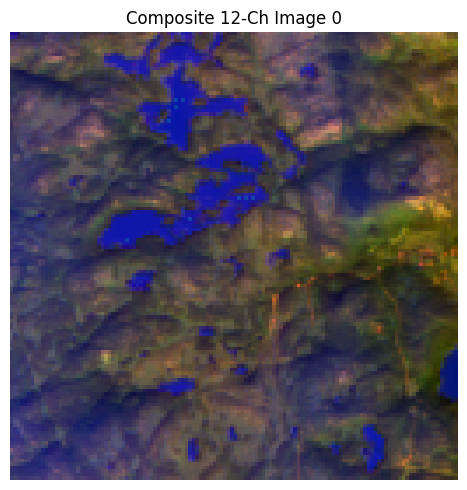


[STEP 4] Plotting individual channels...


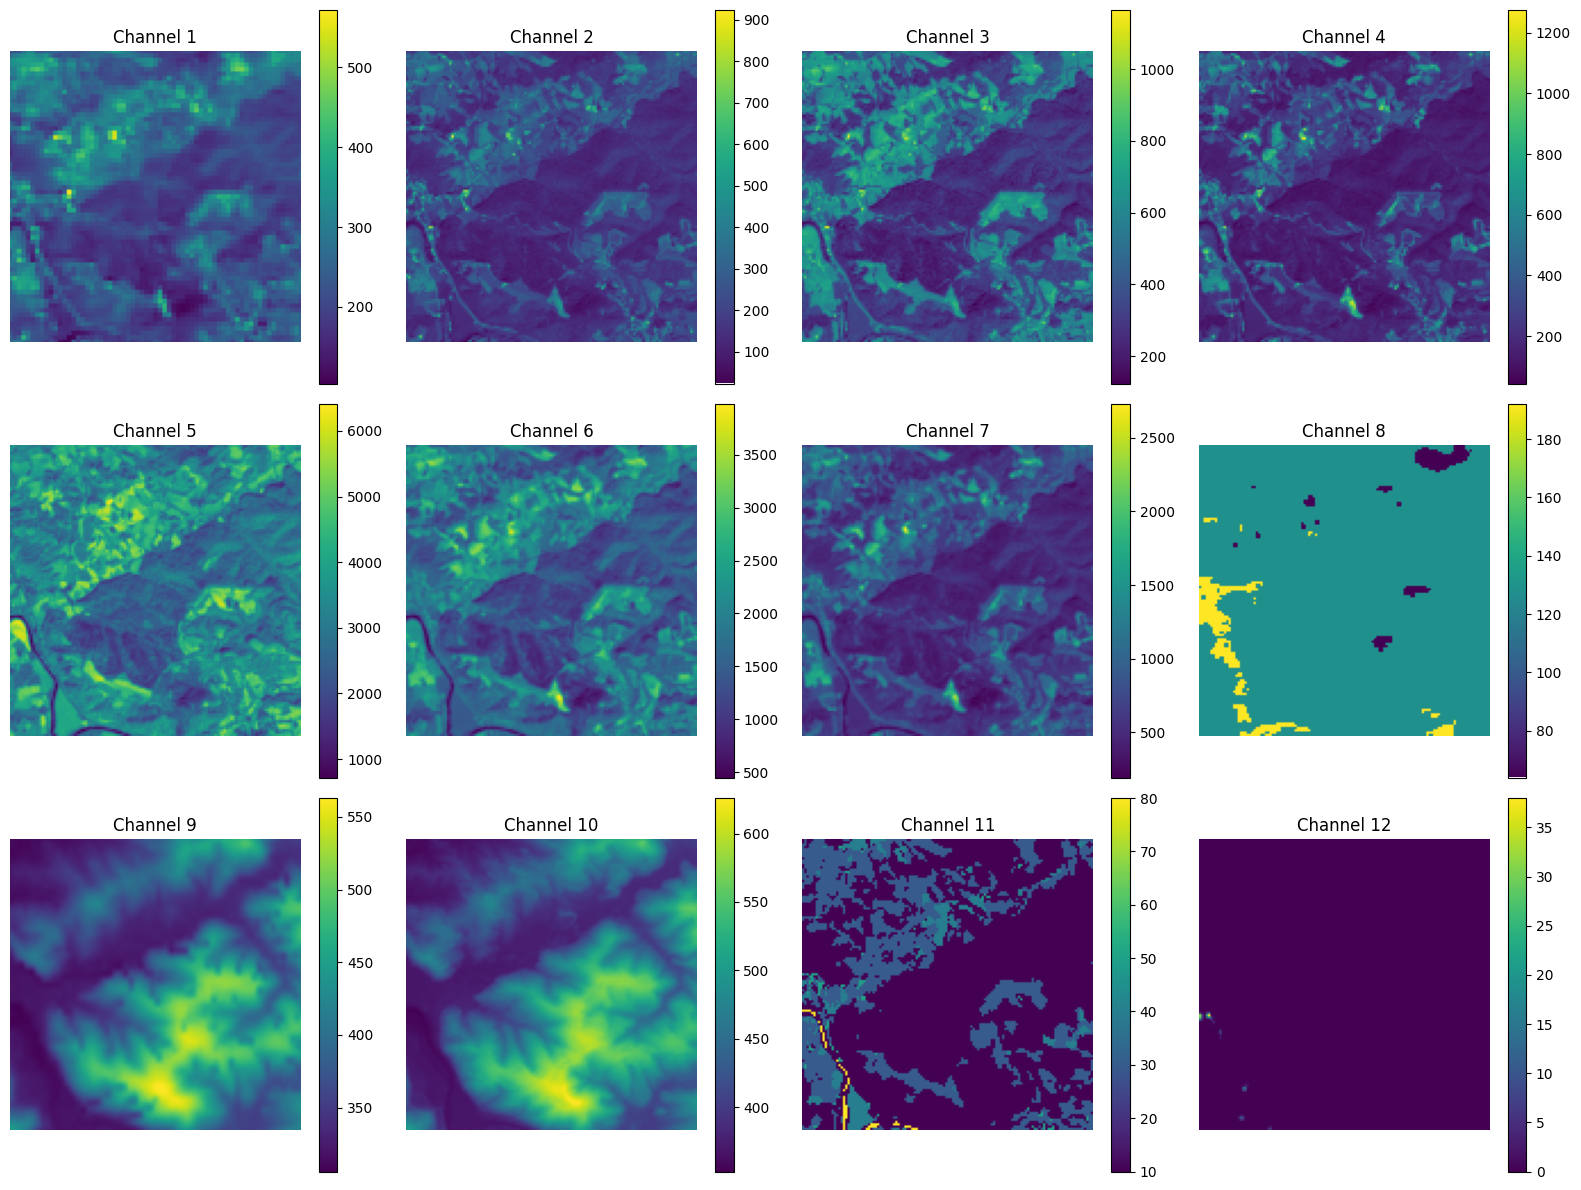


[STEP 5] Filtering selected channels: [2, 3, 4, 5, 6, 10]
✓ Filtered to channels: [2, 3, 4, 5, 6, 10]

[STEP 6] Displaying filtered channels...


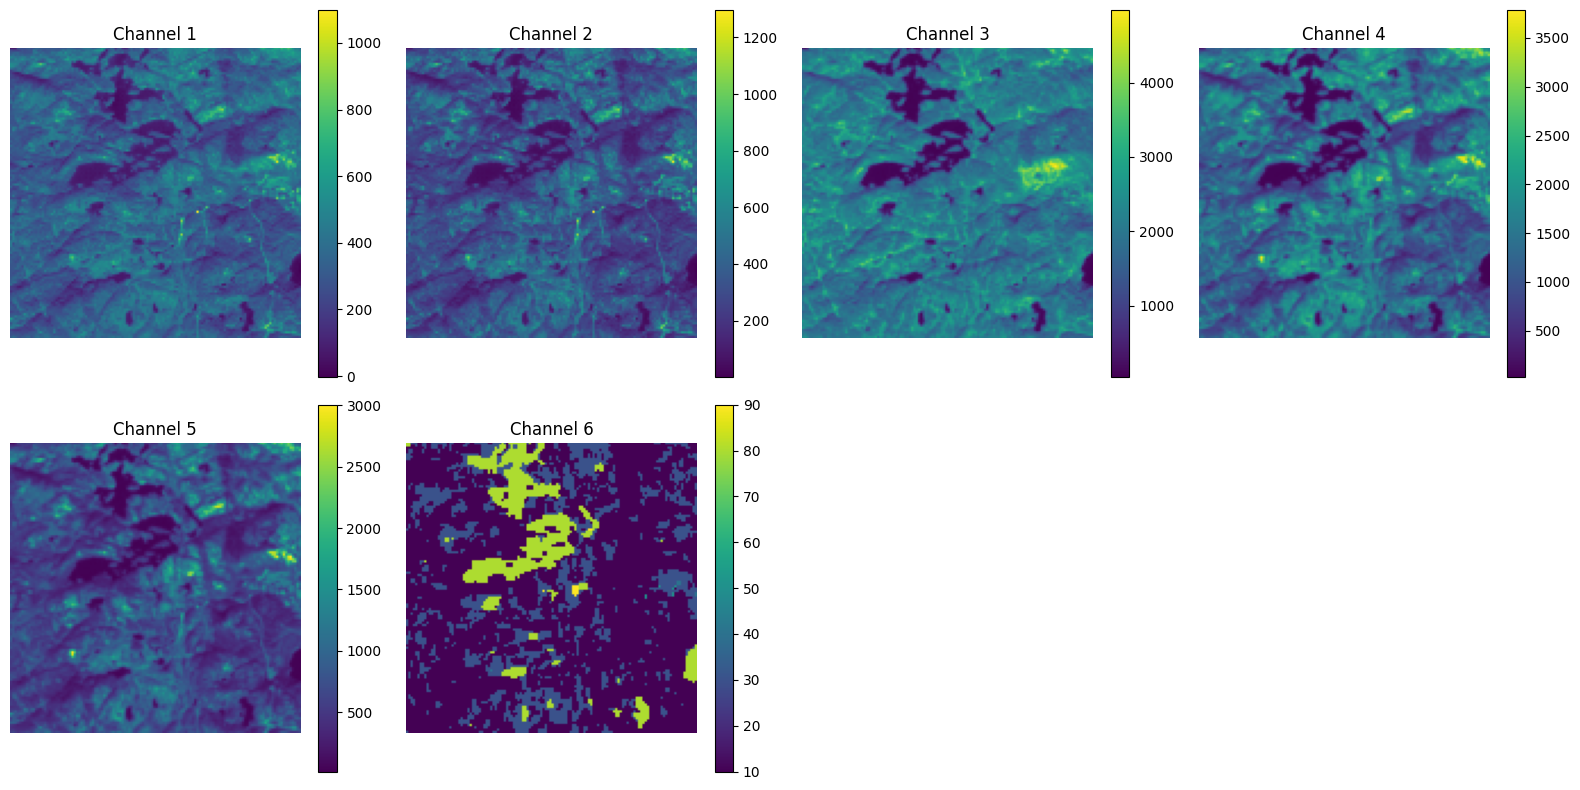


[STEP 7] Normalizing per channel...

[STEP 8] Displaying normalized channels...


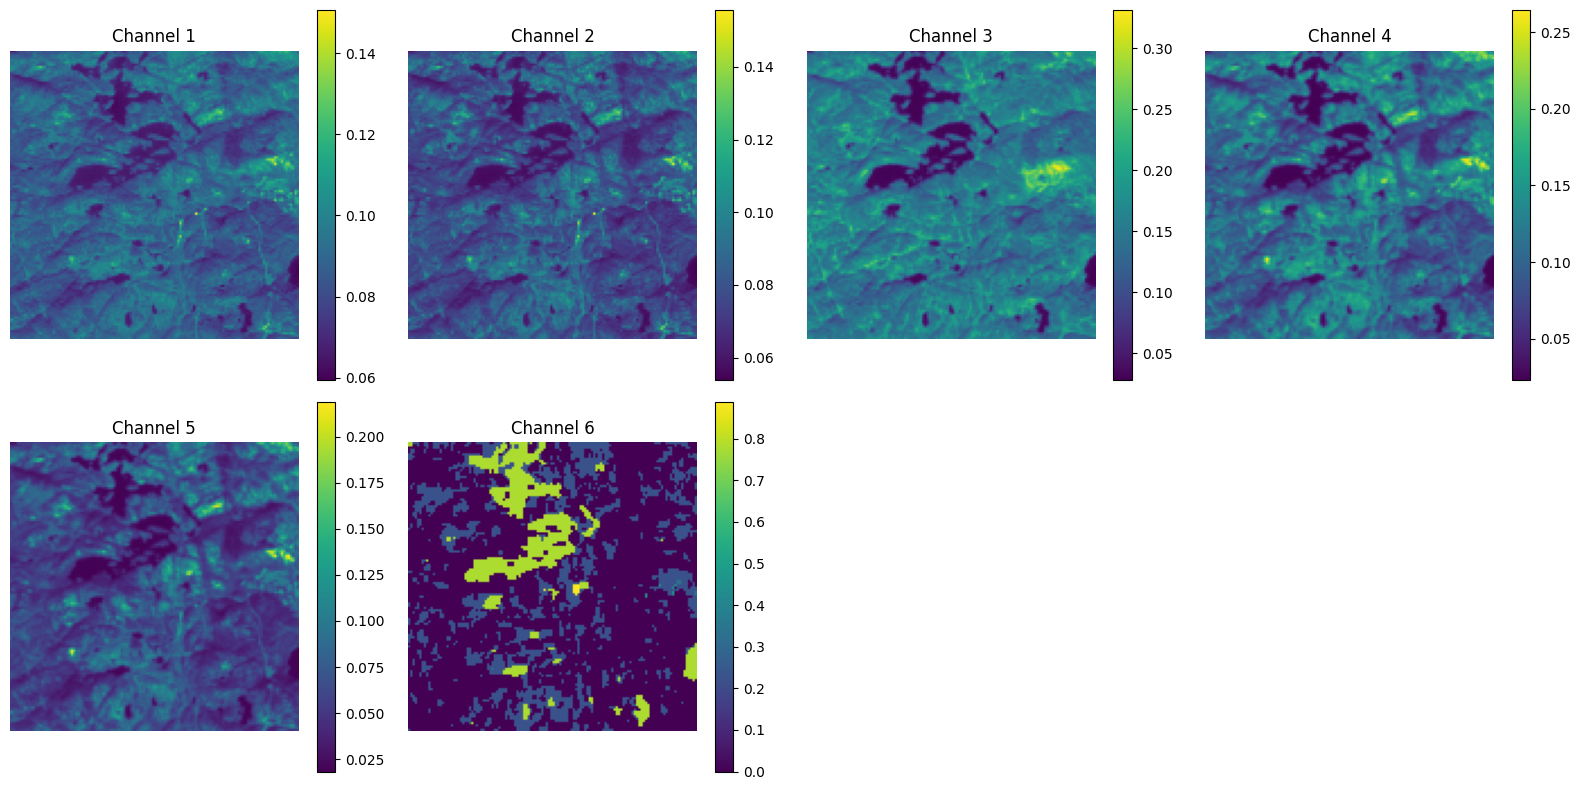


PIPELINE COMPLETED SUCCESSFULLY!
✓ Processed 306 images
✓ Processed 306 labels
✓ Selected 6 channels: [2, 3, 4, 5, 6, 10]
✓ Final image shape: (128, 128, 6)
✅ Data preparation completed!
📊 Dataset info:
   - Images: 306
   - Labels: 306
   - Channels: 6
   - Image shape: (128, 128, 6)


In [9]:
# Execute data preparation
images, labels, pipeline = prepare_data_with_pipeline(
    zip_path=zip_path,
    extract_path=extract_path,
    selected_channels=selected_channels
)

---

## 3. DATA PREPROCESSING FOR DEEP LEARNING

Convert data to appropriate format for DeepLab V3+ training

In [10]:
def preprocess_for_pytorch(images, labels, target_size=(512, 512)):
    """
    Preprocess data for PyTorch DeepLabV3 model
    """
    print("🔄 Preprocessing data for PyTorch...")

    processed_images, processed_masks = [], []

    for image, mask in zip(images, labels):
        # Resize image
        image = np.array(image)
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

        # Resize mask
        mask = np.array(mask)
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        resized_mask = (resized_mask > 0.5).astype(np.float32)

        processed_images.append(resized_image)
        processed_masks.append(resized_mask)

    # Convert to numpy arrays
    processed_images = np.array(processed_images, dtype=np.float32)
    processed_masks = np.array(processed_masks, dtype=np.float32)

    # Convert to PyTorch tensors and adjust dimensions
    # From (N, H, W, C) to (N, C, H, W) for images
    images_tensor = torch.tensor(processed_images).permute(0, 3, 1, 2)
    masks_tensor = torch.tensor(processed_masks)

    print(f"✅ Preprocessing completed!")
    print(f"📊 Tensor shapes:")
    print(f"   - Images: {images_tensor.shape}")
    print(f"   - Masks: {masks_tensor.shape}")
    print(f"   - Image range: [{images_tensor.min():.4f}, {images_tensor.max():.4f}]")
    print(f"   - Mask unique values: {torch.unique(masks_tensor)}")

    return images_tensor, masks_tensor

In [11]:
# Preprocess data
target_size = (512, 512)
X_tensor, y_tensor = preprocess_for_pytorch(images, labels, target_size=target_size)

🔄 Preprocessing data for PyTorch...
✅ Preprocessing completed!
📊 Tensor shapes:
   - Images: torch.Size([306, 6, 512, 512])
   - Masks: torch.Size([306, 512, 512])
   - Image range: [0.0000, 1.0000]
   - Mask unique values: tensor([0., 1.])


---

## 4. DEEPLAB V3+ MODEL ARCHITECTURE

Implement DeepLab V3+ architecture for semantic segmentation

In [12]:
def create_deeplabv3_model(in_channels=6, num_classes=1):
    """
    Create DeepLabV3 model using segmentation_models_pytorch
    """
    print(f"🏗️ Creating DeepLabV3 model...")
    print(f"📐 Input channels: {in_channels}, Output classes: {num_classes}")

    model = smp.DeepLabV3(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=in_channels,
        classes=num_classes,
    )

    print("✅ DeepLabV3 model created successfully!")
    return model

In [13]:
# Create model
in_channels = X_tensor.shape[1]  # Number of channels from preprocessed data
model = create_deeplabv3_model(in_channels=in_channels, num_classes=1)

🏗️ Creating DeepLabV3 model...
📐 Input channels: 6, Output classes: 1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ DeepLabV3 model created successfully!


---

## 5. CUSTOM LOSS FUNCTIONS AND METRICS

Define specialized loss functions for segmentation tasks

In [14]:
def dice_coefficient_torch(y_true, y_pred, smooth=1e-6):
    """Calculate Dice coefficient for PyTorch tensors"""
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)

    intersection = (y_true_flat * y_pred_flat).sum()
    union = y_true_flat.sum() + y_pred_flat.sum()

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [15]:
def iou_metric_torch(y_true, y_pred, threshold=0.5):
    """Calculate IoU metric for PyTorch tensors"""
    y_pred_binary = (y_pred > threshold).float()

    intersection = (y_true * y_pred_binary).sum()
    union = y_true.sum() + y_pred_binary.sum() - intersection

    iou = intersection / (union + 1e-6)
    return iou

---

## 6. MODEL TRAINING SETUP

Configure training parameters, callbacks, and data generators

In [16]:
def setup_training(model, learning_rate=1e-4):
    """Setup training components"""
    print("⚙️ Setting up training configuration...")

    # Loss function combining Dice and BCE
    dice_loss = smp.losses.DiceLoss('binary')
    bce_loss = smp.losses.SoftBCEWithLogitsLoss()

    def combined_loss(pred, target):
        return 0.5 * dice_loss(pred, target) + 0.5 * bce_loss(pred, target)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    print("✅ Training configuration completed!")
    return combined_loss, optimizer, scheduler

In [17]:
def create_data_loaders(X_tensor, y_tensor, batch_size=8, test_size=0.2, val_size=0.15):
    """Create PyTorch data loaders"""
    print("🔄 Creating data loaders...")

    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_tensor, y_tensor, test_size=test_size, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=42
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    print(f"✅ Data loaders created!")
    print(f"📊 Dataset sizes:")
    print(f"   - Train: {len(train_dataset)}")
    print(f"   - Validation: {len(val_dataset)}")
    print(f"   - Test: {len(test_dataset)}")

    return train_loader, val_loader, test_loader, (X_test, y_test)

In [18]:
# Setup training components
loss_fn, optimizer, scheduler = setup_training(model, learning_rate=1e-4)

⚙️ Setting up training configuration...
✅ Training configuration completed!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
# Create data loaders
batch_size = 8
train_loader, val_loader, test_loader, (X_test, y_test) = create_data_loaders(
    X_tensor, y_tensor, batch_size=batch_size
)

🔄 Creating data loaders...
✅ Data loaders created!
📊 Dataset sizes:
   - Train: 198
   - Validation: 46
   - Test: 62


---

## 7. MODEL TRAINING EXECUTION

Execute the training process with monitoring and logging


In [20]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs=50):
    """Train the DeepLabV3 model"""
    print("🚀 Starting model training...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks.unsqueeze(1))

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice_total = 0.0
        val_iou_total = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks.unsqueeze(1))

                # Calculate metrics
                probs = torch.sigmoid(outputs)
                dice = dice_coefficient_torch(masks.unsqueeze(1), probs)
                iou = iou_metric_torch(masks.unsqueeze(1), probs)

                val_loss += loss.item()
                val_dice_total += dice.item()
                val_iou_total += iou.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice_total / len(val_loader)
        avg_val_iou = val_iou_total / len(val_loader)

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_deeplabv3_water_seg.pth')

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_dice'].append(avg_val_dice)
        history['val_iou'].append(avg_val_iou)

        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}")
        print("-" * 50)

    training_time = time.time() - start_time
    print(f"✅ Training completed in {training_time/3600:.2f} hours!")

    return history

In [20]:
# Train the model
epochs = 50
history = train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs)

🚀 Starting model training...
Epoch [1/50]
  Train Loss: 0.4672
  Val Loss: 0.5075, Dice: 0.6148, IoU: 0.5790
--------------------------------------------------
Epoch [2/50]
  Train Loss: 0.3319
  Val Loss: 0.3250, Dice: 0.6556, IoU: 0.5915
--------------------------------------------------
Epoch [3/50]
  Train Loss: 0.3210
  Val Loss: 0.2195, Dice: 0.7723, IoU: 0.7439
--------------------------------------------------
Epoch [4/50]
  Train Loss: 0.2598
  Val Loss: 0.3436, Dice: 0.7252, IoU: 0.6697
--------------------------------------------------
Epoch [5/50]
  Train Loss: 0.2286
  Val Loss: 0.2093, Dice: 0.8040, IoU: 0.7737
--------------------------------------------------
Epoch [6/50]
  Train Loss: 0.2059
  Val Loss: 0.1960, Dice: 0.8149, IoU: 0.7632
--------------------------------------------------
Epoch [7/50]
  Train Loss: 0.1905
  Val Loss: 0.1860, Dice: 0.8259, IoU: 0.7770
--------------------------------------------------
Epoch [8/50]
  Train Loss: 0.1887
  Val Loss: 0.2245, 

In [21]:
# Load the saved model after session crash
# Recreate the model architecture first
model = smp.DeepLabV3(encoder_name="resnet34", encoder_weights="imagenet", in_channels=6, classes=1)

# Load the saved weights
model.load_state_dict(torch.load('best_deeplabv3_water_seg.pth'))

<All keys matched successfully>

---

## 8. TRAINING VISUALIZATION AND ANALYSIS

Visualize training progress and analyze model performance


In [22]:
def evaluate_model_comprehensive(model, X_test, y_test, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]):
    """Comprehensive model evaluation with multiple thresholds"""
    print("🧪 Comprehensive Model Evaluation...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Generate predictions
    print("🔄 Generating predictions...")
    with torch.no_grad():
        X_test_device = X_test.to(device)
        outputs = model(X_test_device)
        probabilities = torch.sigmoid(outputs).cpu().squeeze(1)

    results = {'threshold_results': {}, 'best_threshold': None, 'best_iou': 0}

    for threshold in thresholds:
        print(f"\n📏 Evaluating at threshold: {threshold}")

        # Binarize predictions
        predictions = (probabilities > threshold).float()

        # Calculate metrics
        dice_scores = []
        iou_scores = []

        for i in range(len(y_test)):
            dice = dice_coefficient_torch(y_test[i:i+1], predictions[i:i+1])
            iou = iou_metric_torch(y_test[i:i+1], predictions[i:i+1], threshold=0.5)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

        # Overall metrics
        overall_dice = dice_coefficient_torch(y_test, predictions)
        overall_iou = iou_metric_torch(y_test, predictions, threshold=0.5)
        pixel_accuracy = torch.mean((predictions == y_test).float())

        # Store results
        threshold_result = {
            'threshold': threshold,
            'overall_dice': overall_dice.item(),
            'overall_iou': overall_iou.item(),
            'pixel_accuracy': pixel_accuracy.item(),
            'mean_dice': np.mean(dice_scores),
            'std_dice': np.std(dice_scores),
            'mean_iou': np.mean(iou_scores),
            'std_iou': np.std(iou_scores),
            'dice_scores': dice_scores,
            'iou_scores': iou_scores
        }

        results['threshold_results'][threshold] = threshold_result

        # Track best threshold
        if overall_iou.item() > results['best_iou']:
            results['best_iou'] = overall_iou.item()
            results['best_threshold'] = threshold

        # Print results
        print(f"   📊 Overall Dice: {overall_dice.item():.4f}")
        print(f"   📊 Overall IoU: {overall_iou.item():.4f}")
        print(f"   🎯 Pixel Accuracy: {pixel_accuracy.item():.4f}")
        print(f"   📈 Mean IoU: {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}")

    # Summary
    print("\n" + "="*60)
    print("📊 COMPREHENSIVE EVALUATION SUMMARY")
    print("="*60)
    print(f"🏆 Best Threshold: {results['best_threshold']}")
    print(f"🥇 Best IoU: {results['best_iou']:.4f}")

    best_results = results['threshold_results'][results['best_threshold']]
    iou_scores = best_results['iou_scores']

    print(f"\n📈 IoU Statistics (at best threshold):")
    print(f"   Mean: {np.mean(iou_scores):.4f}")
    print(f"   Std: {np.std(iou_scores):.4f}")
    print(f"   25th percentile: {np.percentile(iou_scores, 25):.4f}")
    print(f"   50th percentile: {np.percentile(iou_scores, 50):.4f}")
    print(f"   75th percentile: {np.percentile(iou_scores, 75):.4f}")
    print(f"   95th percentile: {np.percentile(iou_scores, 95):.4f}")

    # Performance thresholds
    above_05 = np.sum(np.array(iou_scores) > 0.5) / len(iou_scores)
    above_07 = np.sum(np.array(iou_scores) > 0.7) / len(iou_scores)
    above_09 = np.sum(np.array(iou_scores) > 0.9) / len(iou_scores)

    print(f"\n🎯 Performance Thresholds:")
    print(f"   Images with IoU > 0.5: {above_05*100:.1f}%")
    print(f"   Images with IoU > 0.7: {above_07*100:.1f}%")
    print(f"   Images with IoU > 0.9: {above_09*100:.1f}%")
    print("="*60)

    return results, probabilities

In [23]:
# Comprehensive evaluation
evaluation_results, predictions = evaluate_model_comprehensive(
    model, X_test, y_test, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]
)

🧪 Comprehensive Model Evaluation...
🔄 Generating predictions...

📏 Evaluating at threshold: 0.3
   📊 Overall Dice: 0.9154
   📊 Overall IoU: 0.8441
   🎯 Pixel Accuracy: 0.9481
   📈 Mean IoU: 0.6099 ± 0.3700

📏 Evaluating at threshold: 0.4
   📊 Overall Dice: 0.9191
   📊 Overall IoU: 0.8504
   🎯 Pixel Accuracy: 0.9509
   📈 Mean IoU: 0.6126 ± 0.3719

📏 Evaluating at threshold: 0.5
   📊 Overall Dice: 0.9217
   📊 Overall IoU: 0.8547
   🎯 Pixel Accuracy: 0.9530
   📈 Mean IoU: 0.6130 ± 0.3735

📏 Evaluating at threshold: 0.6
   📊 Overall Dice: 0.9234
   📊 Overall IoU: 0.8576
   🎯 Pixel Accuracy: 0.9544
   📈 Mean IoU: 0.6118 ± 0.3743

📏 Evaluating at threshold: 0.7
   📊 Overall Dice: 0.9242
   📊 Overall IoU: 0.8590
   🎯 Pixel Accuracy: 0.9554
   📈 Mean IoU: 0.6087 ± 0.3742

📊 COMPREHENSIVE EVALUATION SUMMARY
🏆 Best Threshold: 0.7
🥇 Best IoU: 0.8590

📈 IoU Statistics (at best threshold):
   Mean: 0.6087
   Std: 0.3742
   25th percentile: 0.2551
   50th percentile: 0.8063
   75th percentile: 0.908

---

## 9. COMPREHENSIVE IoU EVALUATION AND TESTING


Detailed IoU-based evaluation with class-wise analysis and multiple thresholds

In [24]:
def visualize_predictions(X_test, y_test, predictions, num_samples=6, threshold=0.5):
    """Visualize model predictions"""
    print(f"🎨 Visualizing {num_samples} prediction samples...")

    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
    pred_binary = (predictions > threshold).float()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Convert tensor to numpy for visualization
        img = X_test[idx].permute(1, 2, 0).numpy()

        # Create RGB-like display (use first 3 channels)
        if img.shape[-1] >= 3:
            img_rgb = img[:, :, :3]
        else:
            img_rgb = np.stack([img[:, :, 0]] * 3, axis=-1)

        # Normalize for display
        img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min() + 1e-8)

        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title(f'Input Image {idx}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(y_test[idx].numpy(), cmap='Blues')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predictions[idx].numpy(), cmap='Blues', vmin=0, vmax=1)
        axes[i, 2].set_title('Prediction Probability')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(pred_binary[idx].numpy(), cmap='Blues')
        axes[i, 3].set_title(f'Binary Prediction (t={threshold})')
        axes[i, 3].axis('off')

        # Calculate IoU for this sample
        iou = iou_metric_torch(y_test[idx:idx+1], pred_binary[idx:idx+1])
        print(f"Sample {idx} IoU: {iou.item():.3f}")

    plt.tight_layout()
    plt.show()

In [25]:

def plot_evaluation_results(evaluation_results):
    """Plot comprehensive evaluation results"""
    print("📊 Creating evaluation plots...")

    thresholds = list(evaluation_results['threshold_results'].keys())
    dice_scores = [evaluation_results['threshold_results'][t]['overall_dice'] for t in thresholds]
    iou_scores = [evaluation_results['threshold_results'][t]['overall_iou'] for t in thresholds]
    pixel_accuracies = [evaluation_results['threshold_results'][t]['pixel_accuracy'] for t in thresholds]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Metrics vs Threshold
    axes[0].plot(thresholds, dice_scores, 'b-o', label='Dice Score', linewidth=2, markersize=8)
    axes[0].plot(thresholds, iou_scores, 'r-s', label='IoU Score', linewidth=2, markersize=8)
    axes[0].plot(thresholds, pixel_accuracies, 'g-^', label='Pixel Accuracy', linewidth=2, markersize=8)
    axes[0].set_xlabel('Classification Threshold')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Metrics vs Threshold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # IoU Distribution at best threshold
    best_threshold = evaluation_results['best_threshold']
    iou_dist = evaluation_results['threshold_results'][best_threshold]['iou_scores']

    axes[1].hist(iou_dist, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].axvline(np.mean(iou_dist), color='red', linestyle='--',
                   label=f'Mean: {np.mean(iou_dist):.3f}')
    axes[1].axvline(np.median(iou_dist), color='green', linestyle='--',
                   label=f'Median: {np.median(iou_dist):.3f}')
    axes[1].set_xlabel('IoU Score')
    axes[1].set_ylabel('Number of Images')
    axes[1].set_title(f'IoU Distribution (threshold={best_threshold})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Performance thresholds
    iou_scores_best = evaluation_results['threshold_results'][best_threshold]['iou_scores']
    thresholds_perf = [0.5, 0.7, 0.9]
    percentages = []
    for t in thresholds_perf:
        pct = np.sum(np.array(iou_scores_best) > t) / len(iou_scores_best) * 100
        percentages.append(pct)

    bars = axes[2].bar([f'>{t}' for t in thresholds_perf], percentages,
                      color=['lightgreen', 'orange', 'red'], alpha=0.7)
    axes[2].set_ylabel('Percentage of Images (%)')
    axes[2].set_title('Images Exceeding IoU Thresholds')
    axes[2].grid(True, alpha=0.3, axis='y')

    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("✅ Evaluation plots completed!")

🎨 Visualizing 6 prediction samples...
Sample 50 IoU: 0.907
Sample 56 IoU: 0.889
Sample 0 IoU: 0.793
Sample 57 IoU: 0.682
Sample 5 IoU: 0.759
Sample 48 IoU: 0.268


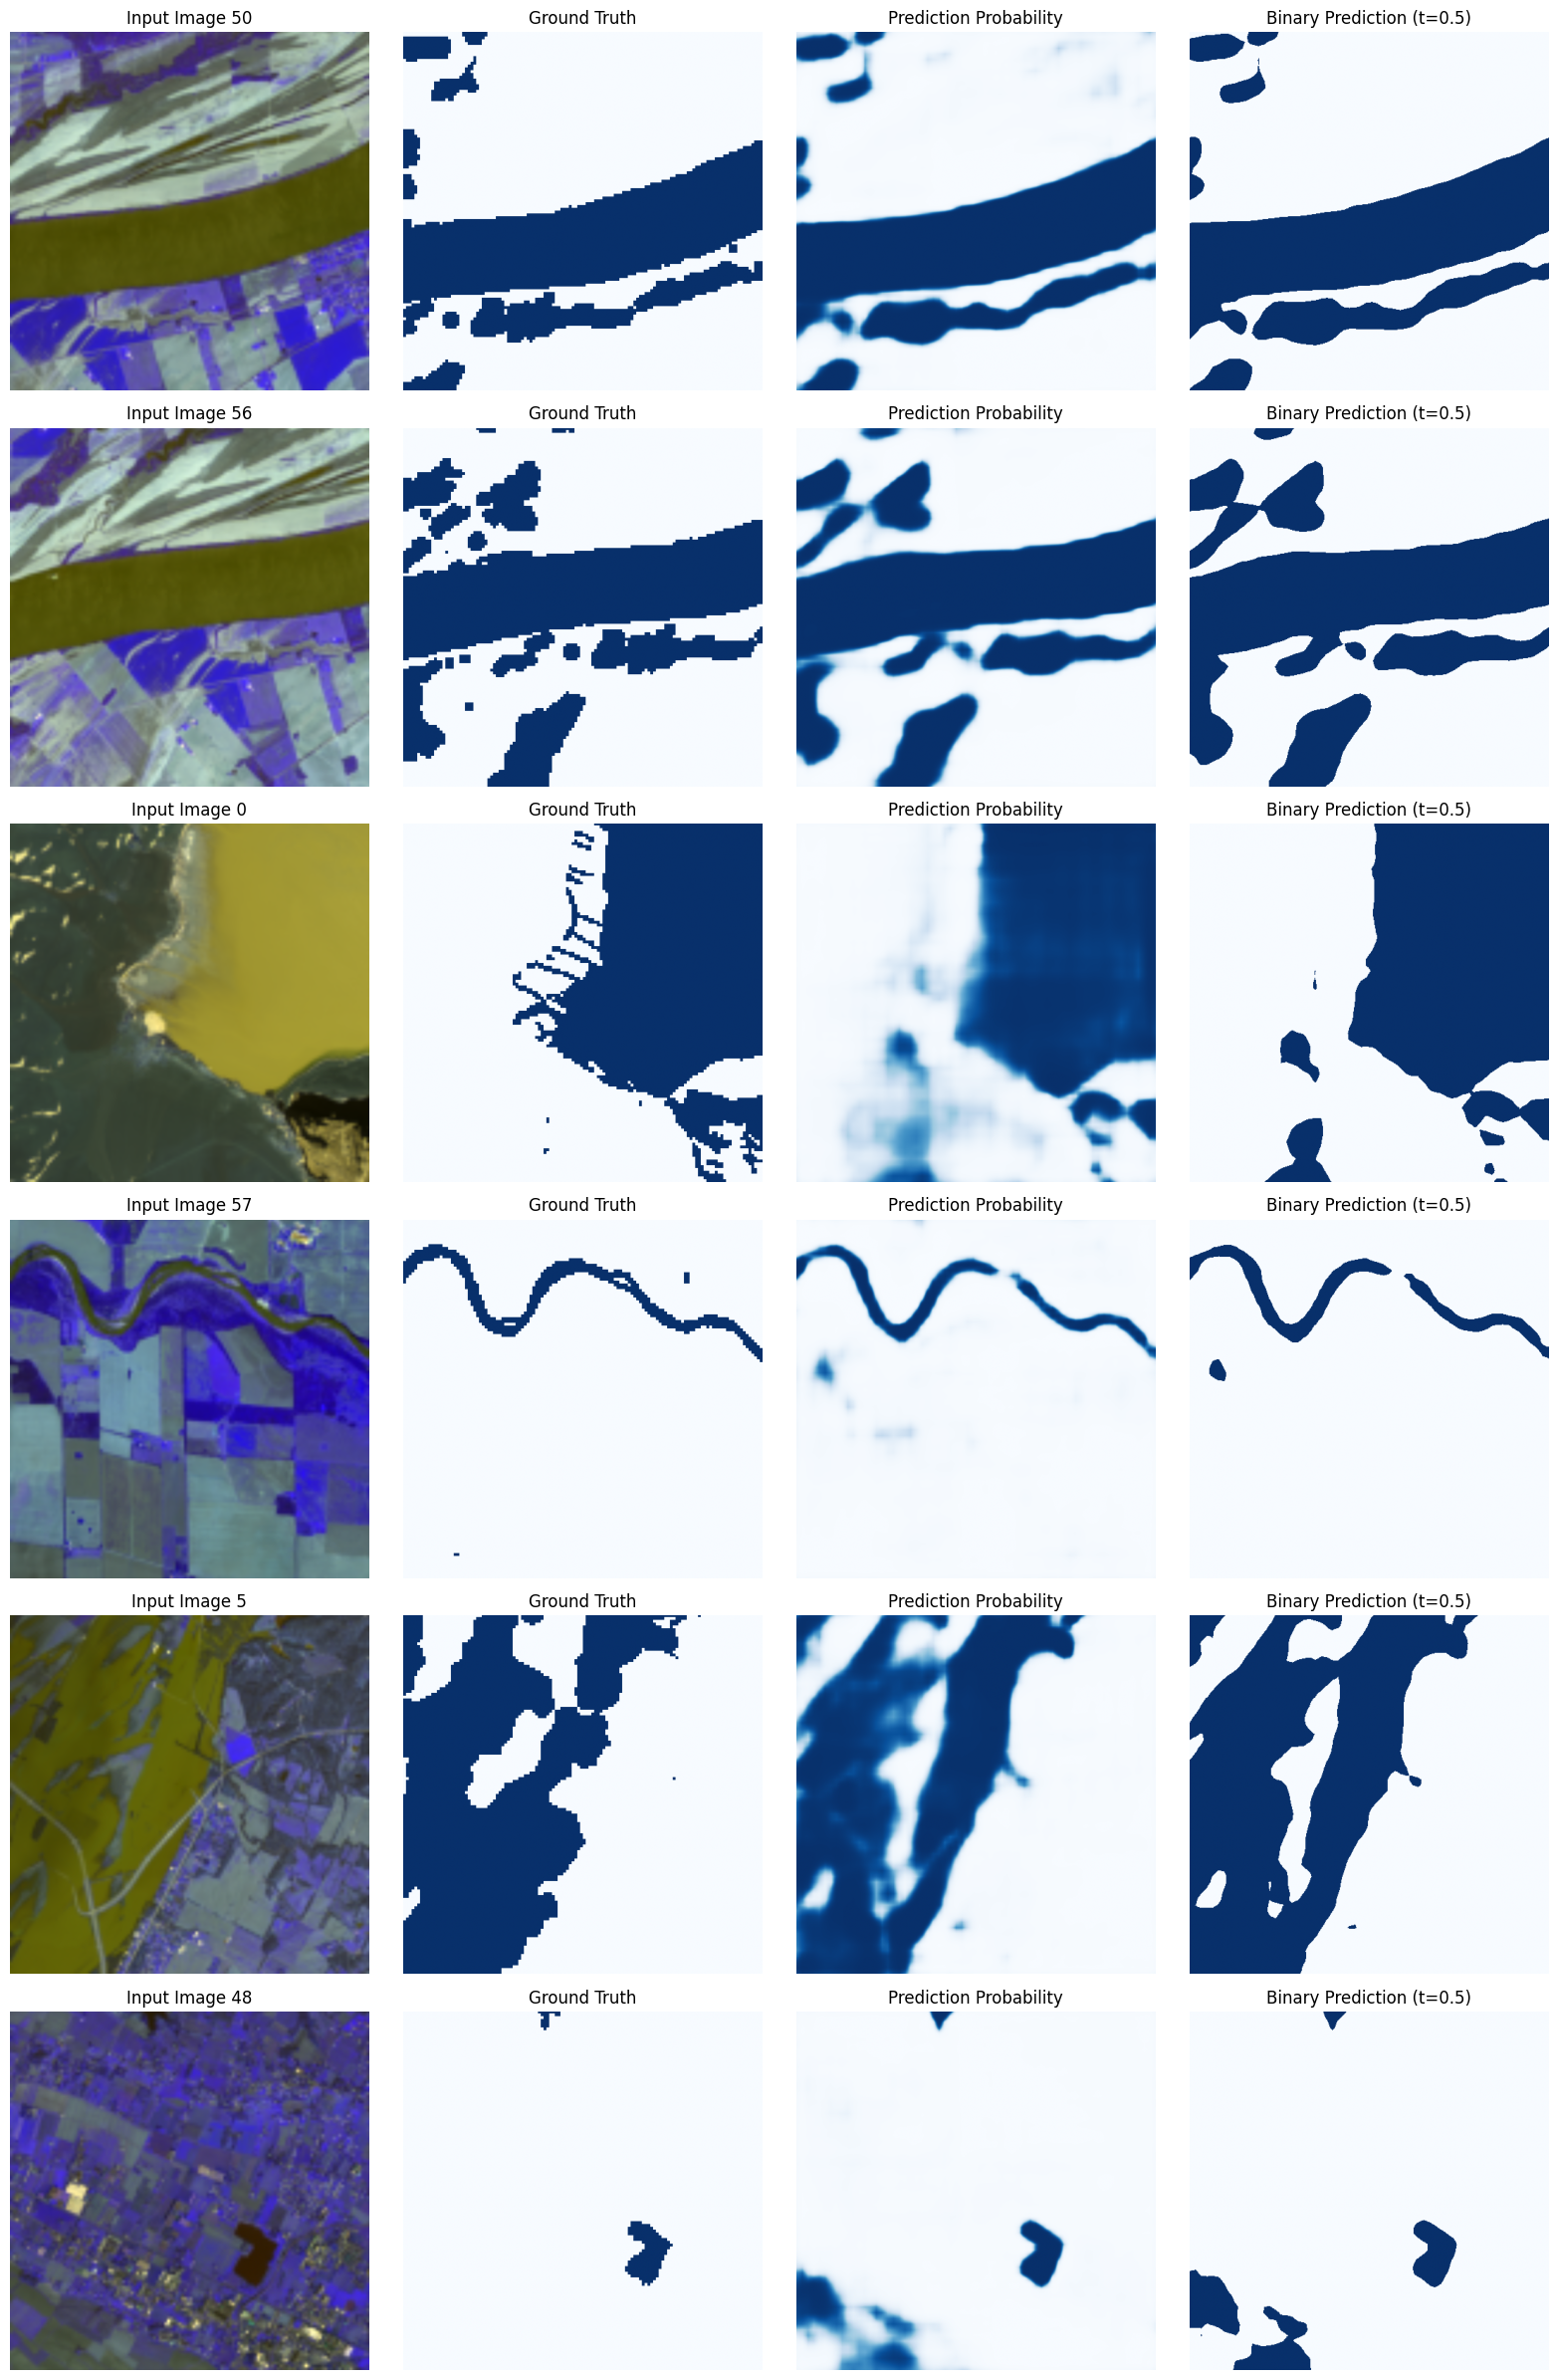

📊 Creating evaluation plots...


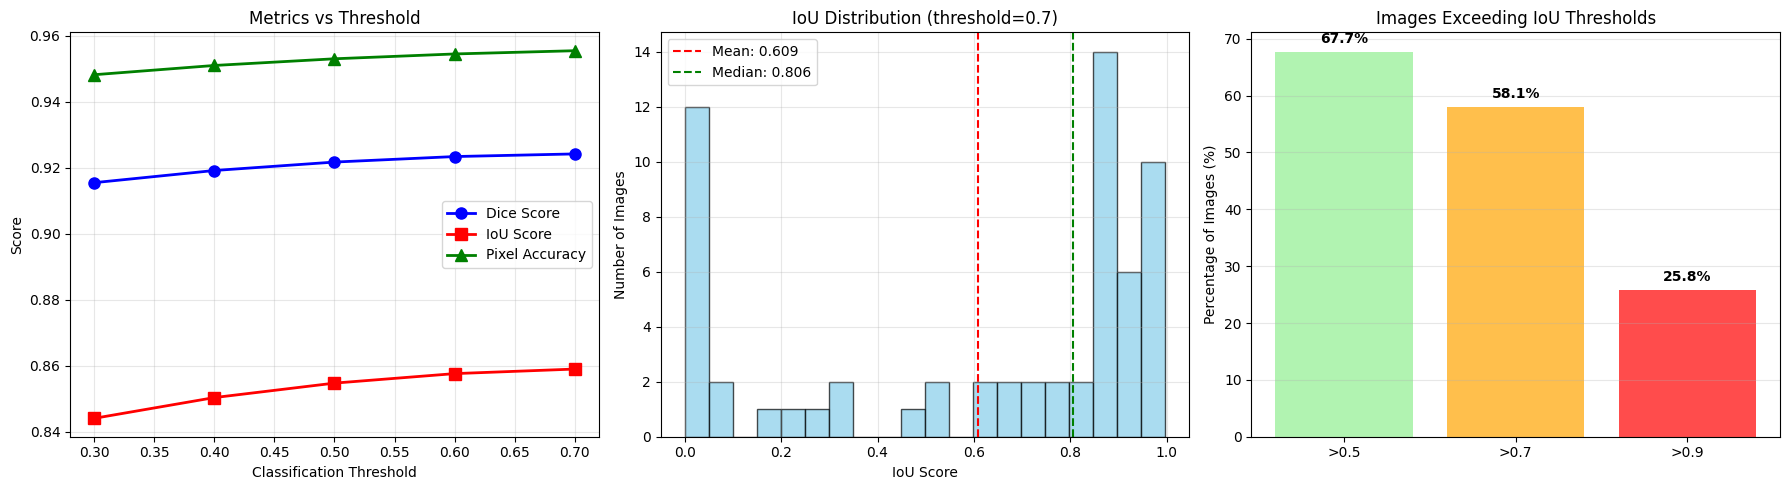

✅ Evaluation plots completed!


In [26]:
# Visualize predictions and results
visualize_predictions(X_test, y_test, predictions, num_samples=6, threshold=0.5)
plot_evaluation_results(evaluation_results)

---

In [27]:
print("=" * 60)
print("🎉 Water segmentation training and evaluation completed successfully!")
print("=" * 60)

🎉 Water segmentation training and evaluation completed successfully!
